# Popular Data Science Questions

In this project, we're going to help people learn by searching for the answer to the question "What is it that people want to learn about in data science?"

In this scenario, we're going to work for a pretend company that creates data science content like books, online articles, videos, and interactive text-based learning platforms. It will be our task to determine the best content for the company to create based on data from [Data Science Stack Exchange](https://datascience.stackexchange.com/). Here we can find what kind of data science content is more popular, and see what people who are new to programming want to know.

Instead of having to scrape the website for data, Stack Exchange provides a public database that we can use [here](https://data.stackexchange.com/datascience/query/new) called the Stack Exchange Data Explorer, or SEDE. We'll be using the Data Science Stack Exchange site –– it is an ideal candidate for data because it is focused on our topic and has a lot of unanswered questions.

Spend some time exploring Stack Exchange if you are not already familiar with it. After spending some time investigating DSSE, you'll find that tags will be useful in categorizing our content.

## Getting the Data

The posts table has a lot of columns that seem relevant to us, specifically the last two columns that tell us how popular the post is. There are 8 different types of posts, but in our analysis, we'll just focus on the most recent question posts. The dataset that is part of this repository contains posts from 2019, but we can still perform the same analysis on our own collected data from 2020 or later if we'd like.

To collect the data, run the following query:

    SELECT Id, CreationDate,
           Score, ViewCount, Tags,
           AnswerCount, FavoriteCount
      FROM posts
     WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;
     
Then, download the CSV provided after running the query.

## Exploring the Data

Let's read in and take a look at our downloaded data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
questions = pd.read_csv('2019_questions.csv', parse_dates=['CreationDate']) # immediately storing CreationDate as a datetime object

In [3]:
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [4]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8839 non-null   int64         
 1   CreationDate   8839 non-null   datetime64[ns]
 2   Score          8839 non-null   int64         
 3   ViewCount      8839 non-null   int64         
 4   Tags           8839 non-null   object        
 5   AnswerCount    8839 non-null   int64         
 6   FavoriteCount  1407 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


`FavoriteCount` appears to have many missing values. These missing values probably mean that the questions wasn't in any users' "favorites" list, so we'll replace the missing values with 0. 

Since `Tags` Dtype is object, let's look ar what types of objects they are. 

In [5]:
questions['Tags'].apply(lambda value: type(value)).unique()

array([<class 'str'>], dtype=object)

It looks like every value in `Tags` is stored as a string. On Stack Exchange, every question can have only five tags, so we could create five columns and populate these columns with their corresponding tags, but we'll just keep them as a list since that wouldn't help us relate the tags from one question to the next.

## Cleaning the Data

We'll start of by fixing `FavoriteCount`.

In [6]:
questions.fillna(value={'FavoriteCount': 0}, inplace=True)
questions['FavoriteCount'] = questions['FavoriteCount'].astype(int)
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

Next, we'll modify `Tags` so the column is easier to work with. Since the tags look like "`<machine-learning><data-mining>`", we'll want to replace the "<>" with `,`, and then split the tags to obtain our list.

In [7]:
questions['Tags'] = questions['Tags'].str.replace('^<|>$', '').str.split('><')
questions.sample(5)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
5610,62808,2019-11-07 06:06:13,0,7,"[machine-learning, nlp]",0,0
1218,57192,2019-08-08 06:57:49,0,43,"[classification, scikit-learn, random-forest, ...",1,0
4975,62355,2019-10-29 11:08:06,0,80,[cnn],2,0
288,44841,2019-01-31 02:42:39,0,18,"[scikit-learn, random-forest, decision-trees]",0,0
4813,50955,2019-04-26 05:34:31,0,33,"[machine-learning, classification, xgboost, cl...",0,0


## Most Used & Most Viewed

Now we'll focus on determining the most popular tags. We'll count how many times the tag was used, and how many times a questions with that tag was viewed. Then we'll create visualizations for the resulting top tags.

In [8]:
tag_count = dict()

for tags in questions['Tags']:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

In [9]:
# Transforming tag_count into a dataframe
tag_count = pd.DataFrame.from_dict(tag_count, orient='index')
tag_count.rename(columns={0: 'Count'}, inplace=True)
tag_count.head(10)

,Count
machine-learning,2693
data-mining,217
regression,347
linear-regression,175
regularization,50
python,1814
time-series,466
forecast,34
forecasting,85
scikit-learn,540


In [10]:
# Sort datafram by Count and visualize the top 20
most_used = tag_count.sort_values(by='Count').tail(20)
most_used

,Count
machine-learning-model,224
statistics,234
clustering,257
predictive-modeling,265
r,268
dataset,340
regression,347
pandas,354
lstm,402
time-series,466


<AxesSubplot:>

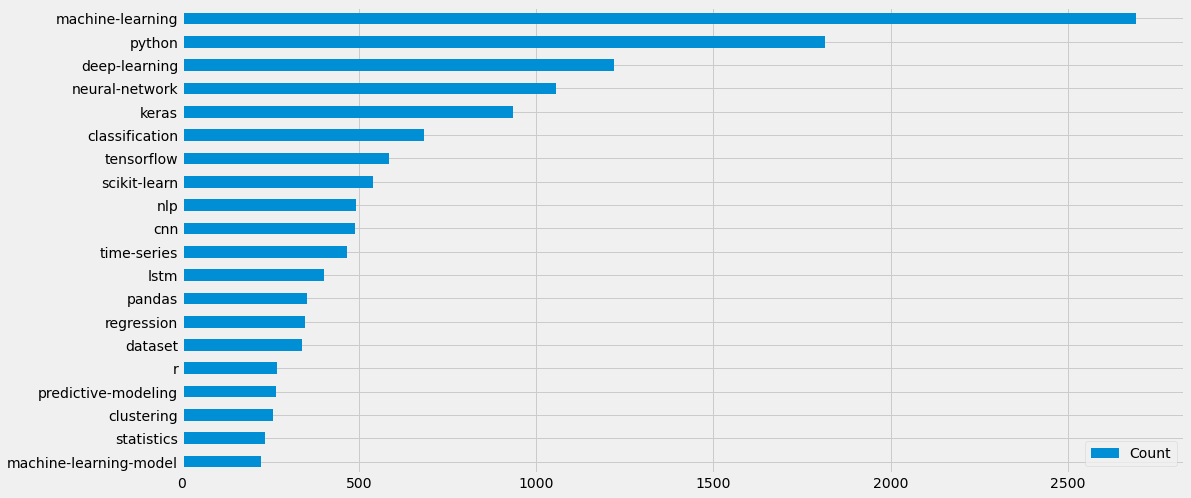

In [11]:
plt.style.use('fivethirtyeight')
most_used.plot(kind='barh', figsize=(16,8))

Next, we'll repeat the process for number of views.

In [12]:
tag_view_count = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']
            
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient='index')
tag_view_count.rename(columns={0: 'ViewCount'}, inplace=True)

most_viewed = tag_view_count.sort_values(by='ViewCount').tail(20)
most_viewed

,ViewCount
clustering,33928
csv,38654
pytorch,40240
dataset,43151
regression,49451
numpy,49767
time-series,64134
cnn,70349
nlp,71382
lstm,74458


<AxesSubplot:>

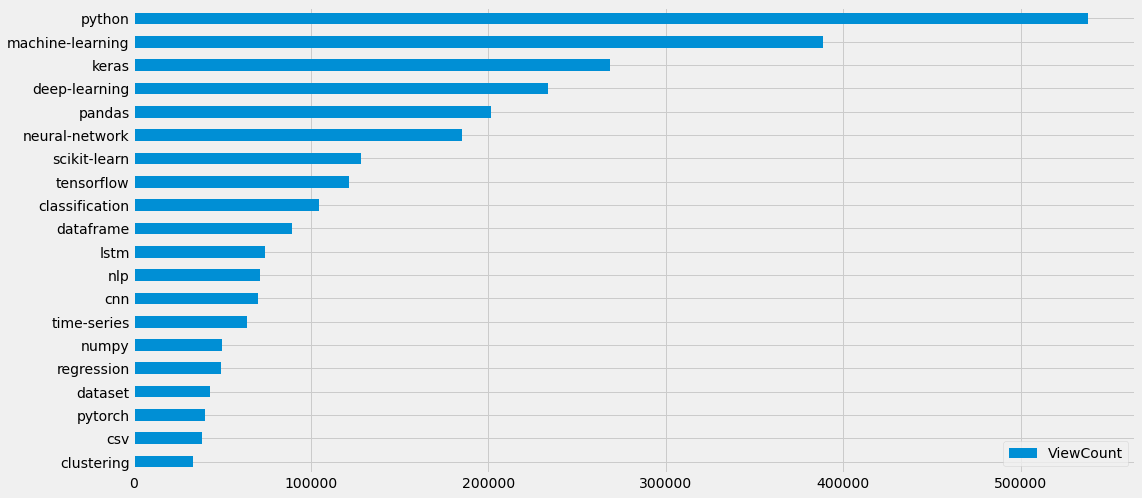

In [13]:
most_viewed.plot(kind='barh', figsize=(16,8))

Let's view the plots side by side.

array([<AxesSubplot:title={'center':'ViewCount'}>], dtype=object)

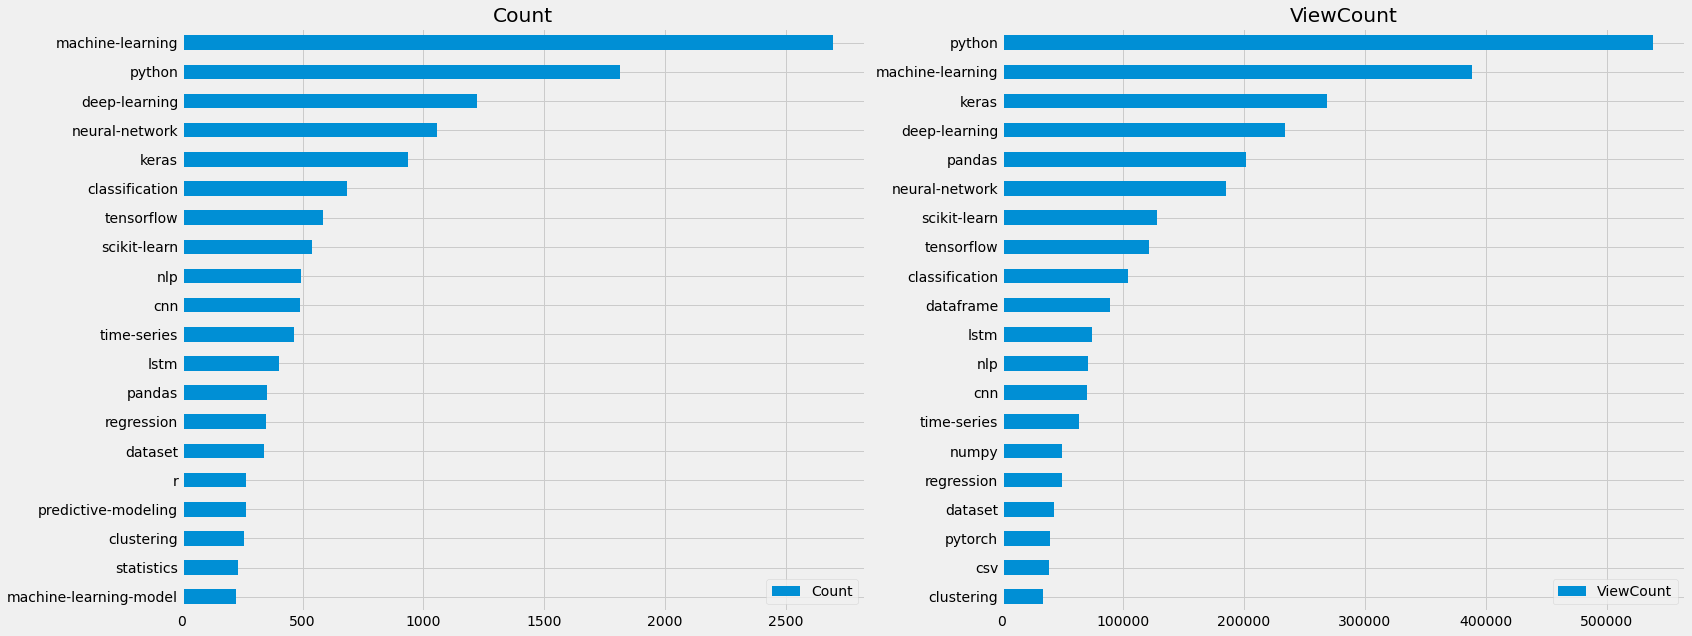

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind='barh', ax=axes[0], subplots=True)
most_viewed.plot(kind='barh', ax=axes[1], subplots=True)

## Relations Between Tags

Most of the top tags appear to be present in both dataframes. Let's see which tags are in `most_used` but not in `most_viewed` and vice versa.

In [15]:
in_used = pd.merge(most_used, most_viewed, how='left', left_index=True, right_index=True)
in_used

,Count,ViewCount
machine-learning-model,224,NaN
statistics,234,NaN
clustering,257,33928.0
predictive-modeling,265,NaN
r,268,NaN
dataset,340,43151.0
regression,347,49451.0
pandas,354,201787.0
lstm,402,74458.0
time-series,466,64134.0


In [16]:
in_viewed = pd.merge(most_used, most_viewed, how='right', left_index=True, right_index=True)
in_viewed

,Count,ViewCount
clustering,257.0,33928
csv,NaN,38654
pytorch,NaN,40240
dataset,340.0,43151
regression,347.0,49451
numpy,NaN,49767
time-series,466.0,64134
cnn,489.0,70349
nlp,493.0,71382
lstm,402.0,74458


The tags in `most_used` but not in `most_viewed` are:

* machine-learning-model
* statistics
* predictive-modeling
* r

The tags in `most_viewed` but not in `most_used` are:

* csv
* pytorch
* dataframe

Also, some tags are related like `python` and `pandas`, but other pairs of tags like `pandas` and `r` should not be. Let's explore this further.

We'll start by creating a list of all tags. Then we'll create a dataframe where each row and column will represent a tag.

In [17]:
all_tags = list(tag_count.index)

associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.iloc[0:4,0:4]

,machine-learning,data-mining,regression,linear-regression
machine-learning,NaN,NaN,NaN,NaN
data-mining,NaN,NaN,NaN,NaN
regression,NaN,NaN,NaN,NaN
linear-regression,NaN,NaN,NaN,NaN


Next, we'll fill the dataframe with zeroes. Then, for each list of tags, we'll increment the intervening tags by one. This way, for each pair of tags, we'll know how many times they were used together.

In [18]:
associations.fillna(0, inplace=True)

for tags in questions['Tags']:
    associations.loc[tags, tags] += 1

The resulting dataframe is very large, so we'll focus on the most used tags and add some colors to make it easier to discuss.

In [19]:
relations_most_used = associations.loc[most_used.index, most_used.index]

def style_cells(x):
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc['time-series', 'r'] = 'background-color: yellow'
    helper_df.loc['r', 'time-series'] = 'background-color: yellow'
    for k in range(helper_df.shape[0]):
        helper_df.iloc[k,k] = 'color: blue'
        
    return helper_df

relations_most_used.style.apply(style_cells, axis=None)

,machine-learning-model,statistics,clustering,predictive-modeling,r,dataset,regression,pandas,lstm,time-series,cnn,nlp,scikit-learn,tensorflow,classification,keras,neural-network,deep-learning,python,machine-learning
machine-learning-model,224,3,3,21,7,12,8,4,5,7,4,4,18,9,21,17,10,19,37,139
statistics,3,234,3,16,16,17,16,3,1,22,1,3,6,0,19,3,11,12,35,89
clustering,3,3,257,0,16,5,2,5,3,20,0,9,24,0,12,0,8,2,45,61
predictive-modeling,21,16,0,265,13,7,28,4,13,31,6,1,12,6,27,11,13,32,35,123
r,7,16,16,13,268,6,10,2,3,22,2,4,1,1,10,10,9,5,24,63
dataset,12,17,5,7,6,340,6,14,7,6,11,11,9,9,28,13,20,32,53,99
regression,8,16,2,28,10,6,347,6,11,24,6,2,37,9,34,31,42,21,59,119
pandas,4,3,5,4,2,14,6,354,7,19,1,3,37,3,3,3,1,1,244,62
lstm,5,1,3,13,3,7,11,7,402,87,24,19,2,43,20,133,69,103,61,71
time-series,7,22,20,31,22,6,24,19,87,466,8,0,12,9,25,51,33,44,105,131


The highlighted cells show us that `time-series` was used with `r` 22 times. The blue values show us how many times each of the tags was used.

It's hard to understand what's going on by looking at this dataframe, so we'll create a heatmap.

In [20]:
# Remove the values in blue so that the colors won't be too skewed
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = np.NaN

<AxesSubplot:>

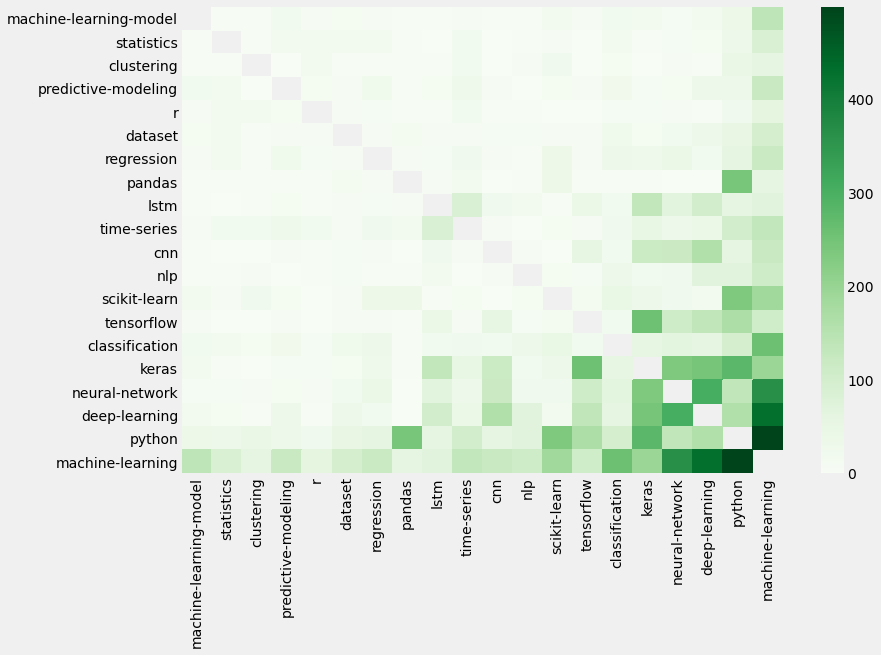

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap='Greens', annot=False)

The most used tags are also the ones with the strongest relationships. However, this could be just because these tags are used so much that they end up being used together even if there is no direct relation between them. This analysis also only looks at related pairs of tags and not multiple groups of tags.

To get around these issues, we could decide to use a data mining technique called association rules. It would help us get a better idea of the relationships between the tags by showing us how strong their relationship is, and how independent the components of the relationship are.

## Enter Domain Knowledge

Domain knowledge can be very useful in finding out what data science topics people want to know more about. For example, `Keras`, `scikit-learn`, `TensorFlow`, and `PyTorch` are all deep learning libraries. Almost all of our top tags are related to deep learning, so it's pretty clear what our answer is.

But is this just a fad?

Let's do a little more analysis to see if this is just a fad. To do this, we'll read in a file that contains all question data, and not just 2019 data. The file in our repository is called `all_questions.csv`, but you can use the following query and download the most recent data yourself:

    SELECT Id, CreationDate, Tags
      FROM posts
     WHERE PostTypeId = 1;

By using this data, we'll be able to track the interest of deep learning over time.

In [22]:
all_q = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])

We'll clean our data using the same techniques we used earlier.

In [23]:
all_q['Tags'] = all_q['Tags'].str.replace('^<|>$', '').str.split('><')

Let's decide what tags should be classified as being deep learning related. After looking at all the tags in `most_used` and seeing which ones relate to deep learning, we can come up with the following list: `["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]`.

Next, we'll write a function that assigns `1` to deep learning questions and `0` to all others.

In [24]:
def deep_learning_class(tags):
    for tag in tags:
        if tag in ['lstm', 'cnn', 'scikit-learn', 'tensorflow', 'keras', 'neural-network', 'deep-learning']:
            return 1
    return 0

In [25]:
all_q['DeepLearning'] = all_q['Tags'].apply(deep_learning_class)
all_q.sample(5)

,Id,CreationDate,Tags,DeepLearning
12307,30264,2018-04-13 10:00:30,"[scikit-learn, clustering, k-means, prediction...",1
7495,6387,2015-07-08 07:35:31,"[nlp, data-formats]",0
7232,27686,2018-02-10 22:47:48,"[reference-request, definitions, ai]",0
20389,65758,2020-01-02 20:45:37,"[machine-learning, deep-learning, keras, tenso...",1
17564,63843,2019-11-27 11:13:52,"[lstm, data-science-model]",1


Our function works. Let's track our data science tags quarterly. Since we don't have all the data for the first quarter of 2020, we'll keep those dates out of our dataframe.

In [26]:
all_q = all_q[all_q['CreationDate'].dt.year < 2020]

Now we'll create a column containing the quarter in which a question was asked.

In [27]:
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return '{y}Q{q}'.format(y=year, q=quarter)

all_q['Quarter'] = all_q['CreationDate'].apply(fetch_quarter)
all_q.head()

,Id,CreationDate,Tags,DeepLearning,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],1,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,19Q1
3,45426,2019-02-12 04:51:49,[keras],1,19Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0,19Q1


For the last part, we'll group by quarter and:
* Count the number of deep learning questions.
* Count the total number of questions.
* Calculate the ratio of these results.

In [28]:
quarterly = all_q.groupby('Quarter').agg({'DeepLearning': ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly['DeepLearningRate'] = quarterly['DeepLearningQuestions'] / quarterly['TotalQuestions']

# To help with visualizing the data
quarterly.reset_index(inplace=True)
quarterly.sample(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
14,17Q4,353,898,0.393096
7,16Q1,110,516,0.213178
8,16Q2,109,518,0.210425
12,17Q2,226,647,0.349304
13,17Q3,247,714,0.345938


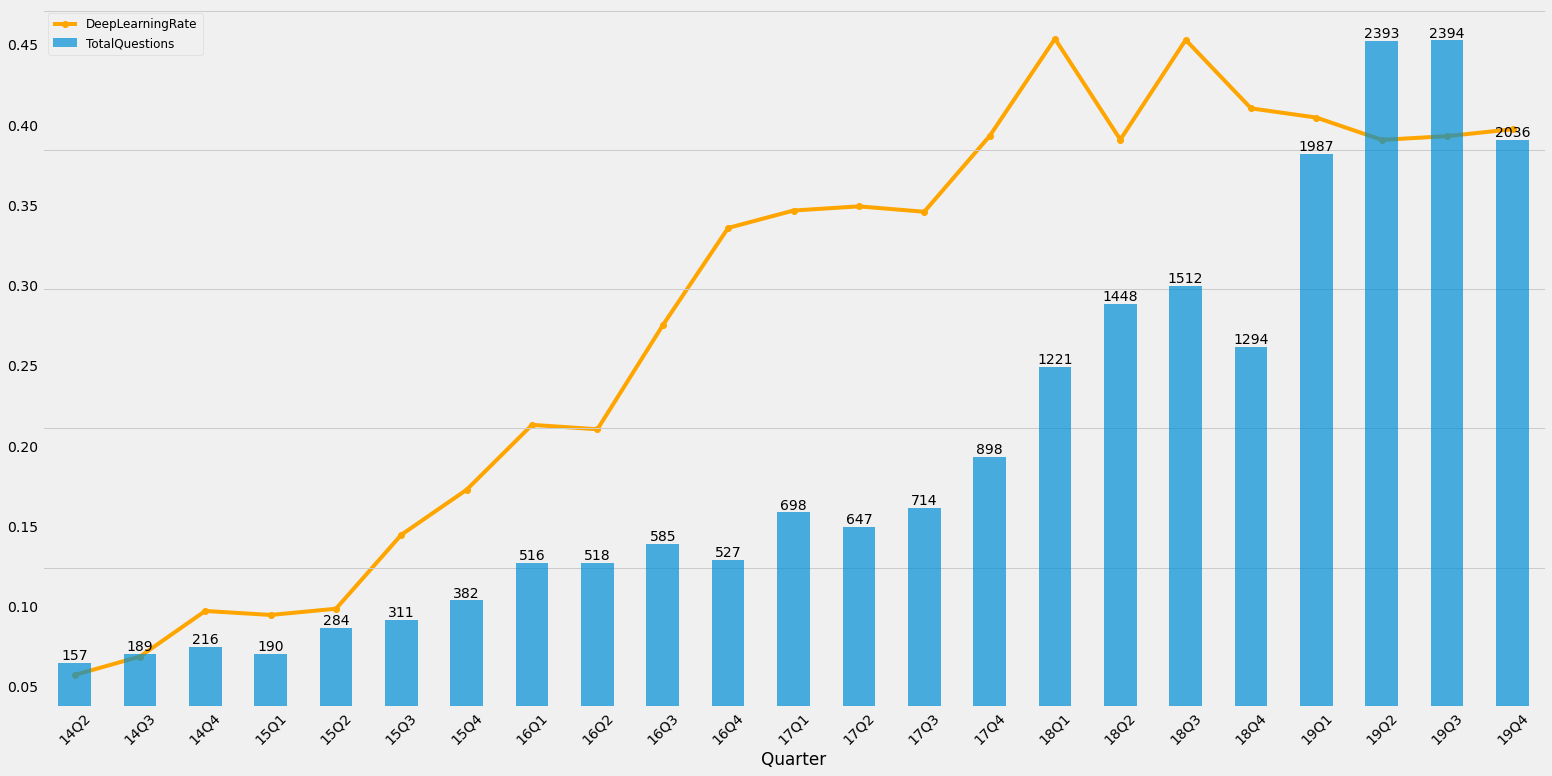

In [29]:
# Plotting our deep learning and total question data by quarter
ax1 = quarterly.plot(x='Quarter', y='DeepLearningRate', kind='line', linestyle='-', marker='o', color='orange',
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x='Quarter', y='TotalQuestions', kind='bar', ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly['TotalQuestions'].iteritems():
    ax2.text(idx, t, str(t), ha='center', va='bottom')
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper left', prop={'size': 12})

for ax in (ax1, ax2):
    for where in ('top', 'right'):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

From what we can see in our visualization, deep learning questions had a phase of high-growth, and the most recent data suggests that the topic might be plateauing. Since interest in deep learning doesn't seem to be decreasing at all, we'll maintain our position and propose that we create more deep learning content.

## Conclusion & Next Steps

In this project, we analyzed data from Data Science Stack Exchange to figure out what it is that people want to learn about in data science.

If we want to continue our analysis, some things we could do next are:

* Look at other content that we can recommend that isn't popular. We could use association rules to find strong relations between tags.
* Look at other popularity features that we could include in our analysis, like scores and favorite counts.
* Look at other sites other than DSSE.
* Find other content to write about that isn't specifically about data science that people in data science want to know more about.

The idea for this project comes from the [DATAQUEST](https://app.dataquest.io/) **Data Analysis in Business** course.